In [ ]:
# imports
# from __future__ import division, print_function
import numpy as np
import pandas as pd
import os
import sys
import string
import scipy.integrate as itg
import scipy.optimize as opt
import scipy.ndimage as ndi
import matplotlib.pyplot as plt 
import matplotlib.animation as anm
from matplotlib import cm
import skimage.measure
import skimage.filters
import numba
import gc
from multiprocessing import Pool, Process
import emcee as mc
import seaborn as sns

%load_ext line_profiler

from IPython.display import HTML


rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 24, 
      'xtick.labelsize': 18, 
      'ytick.labelsize': 18, 
      'legend.fontsize': 18,
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)


%matplotlib inline


In [2]:
sub_arr_list = []

def_emph = [3,5,10,12,7,11,13,14,15]
alt_emph = [3,5,10,12,7,11,13,14,15]
for xx in np.arange(16):
    a = np.floor(xx / 8)
    b = np.floor((xx - a*8) / 4)
    c = np.floor((xx - a*8 - b*4) / 2)
    d = xx - a*8 - b*4 - c*2
    sub_arr_list.append(np.array([[a, b], [c, d]]))

def binarize(xx):
    a = np.floor(xx / 8)
    b = np.floor((xx - a*8) / 4)
    c = np.floor((xx - a*8 - b*4) / 2)
    d = xx - a*8 - b*4 - c*2
    return a, b, c, d
    
def gen_perc_arr(n=100, phi=0.5):
    arr = np.random.random((n,n)) > phi
    return arr

def gen_perc_diff_arr(n=200, phi=0.5, phi_d=1.1, emph=[3,5,10,12,7,11,13,14,15]):
    # Create arrays
    arr = np.random.random((n,n))
    arr_out = np.zeros((n*2,n*2))
    # Create CDF for sub array generation
    tot_p = 16 + (phi_d - 1)*len(emph)
    cutoffs = np.zeros(16)
    runsum = 0 
    for i in np.arange(16):
        if i in emph:
            runsum += phi_d / tot_p
        else:
            runsum += 1 / tot_p
        cutoffs[i] = runsum
#     print(cutoffs)
    # Populate out array with sub arrays
    ind_vec = np.arange(16)
    for i in np.arange(n):
        for j in np.arange(n):
            ind_choices = [xx for xx in ind_vec if arr[i,j] < cutoffs[xx]]
#             print(ind_choices, arr[i,j])
            sub_arr_ind = ind_choices[0]
            arr_out[2*i:(2*i+2),2*j:(2*j+2)] += sub_arr_list[sub_arr_ind]
    return arr_out

def label_arr(arr):
    labeled = skimage.measure.label(arr, connectivity=1)
    nlab = np.max(labeled)
    sizes = np.array([np.sum(labeled == xx) for xx in np.arange(1,nlab+1)])
    return sizes

# plt.plot(np.linspace(0,3,5),np.power(10,np.linspace(1,-5,5)))
#     plt.imshow(labeled)
#     plt.title(np.max(labeled))


Text(0.5,1,'Varying enrinchment of paths')

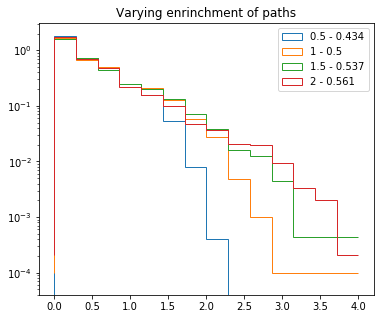

In [3]:
plt.figure(figsize=(6,5))
for phi_d in [0.5,1,1.5,2]:
    arr = gen_perc_diff_arr(phi_d=phi_d, phi=0.5, n=200) > 0
    labeled = skimage.measure.label(arr, connectivity=1)
    nlab = np.max(labeled)
    emp_phi = np.round(arr.sum() / arr.size, 3)
    sizes = np.log10(np.array([np.sum(labeled == xx) for xx in np.arange(1,nlab+1)]))
    _ = plt.hist(sizes, log=True, density=True, histtype='step',bins=np.linspace(0,4,15), label="{} - {}".format(phi_d, emp_phi))
plt.legend()
plt.title('Varying enrinchment of paths')

Text(0.5,1,'Gaussian filtered random arrays')

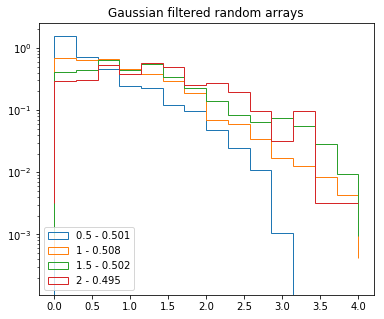

In [4]:
plt.figure(figsize=(6,5))
phi=0.5
for phi_d in [0.5,1,1.5,2]:
    arr = skimage.filters.gaussian(np.random.random((400,400)), phi_d) > phi
    labeled = skimage.measure.label(arr, connectivity=1)
    nlab = np.max(labeled)
    emp_phi = np.round(arr.sum() / arr.size, 3)
    sizes = np.log10(np.array([np.sum(labeled == xx) for xx in np.arange(1,nlab+1)]))
    _ = plt.hist(sizes, log=True, density=True, histtype='step',bins=np.linspace(0,4,15), label="{} - {}".format(phi_d, emp_phi))
plt.legend()
plt.title('Gaussian filtered random arrays')

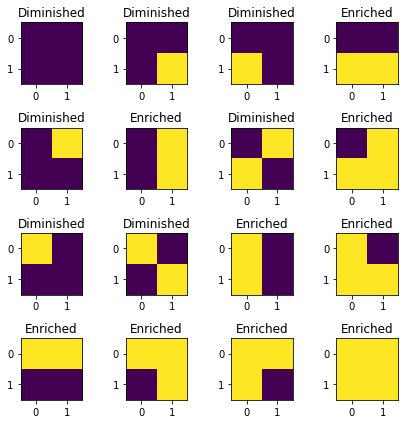

In [5]:
# np.power(10,np.linspace(1,-6,5))
fig, axs = plt.subplots(4,4,figsize=(6,6))
for ii, sub_arr in enumerate(sub_arr_list):
    a, b, c, d = [np.int(xx) for xx in binarize(ii)]
#     print(a,b,c,d)
    ax = axs[2*a+b, 2*c+d]
    ax.imshow(sub_arr, vmin=0, vmax=1)
    if ii in def_emph:
        ax.set_title('Enriched')
    else:
        ax.set_title('Diminished')
fig.tight_layout()
#     plt.title(ii)

# PDE Modelling 

## Objectives 
* Make a model that describes cell growth and signalling at the scale of colonies 

## Model considerations 
* Species
    1. Cell density 
    1. Nutrient density 
    1. Environmental AHL (considered equal to intracellular concentration)
    1. Synthase / GFP
    1. Repressor or degradase
* Reactions 
    1. cell growth and diffusion 
        * Cells diffuse very slowly
        * nutrient-dependent growth (from Liu et al 2011, Science) 
        $$  $$ 
    1. Transcriptional activation
        * Basal protein expression -> scaled by repression? probably
        * Activation by internal AHL 
        * Use Hill function $$H(A(t), n, k) = \frac{A(t)^2}{k^n + A(t)^n}$$
        * Activation term, with basal expression and expression rate x
        $$X(A(t), n, k, b, x) = x\frac{A(t)^2}{k^n + A(t)^n} + b$$
    1. Transcriptional repression
        * Assume activation is AND-like, meaning that repression trumps activation
        * Use 'repression' Hill function $$H_n(R(t), n, k) = \frac{k^n}{k^n + R(t)^n}$$
        * Rather than considering protein concentrations within cells, calculate protein concentrations as produced by the bulk of cells. Expression is therefore proportional to cell density.
    1. Dilution and degradation 
        * Assume that GFP/Synthase proteins are degradation tagged
        * Degradase is not tagged, so does not have a degradation term
    1. Diffusion 
        * Here, you're going to use convoultion of the diffusion kernel
        * Diffusion in/out of cell is considered faster than spatial diffusion at these scales
    1. Parameters
        * We are also assuming, for the moment, that each time point is 6 minutes. Parameters with time dimensions shown below may use different units than the parameter from the cited paper.
        * dx: Length modification of diffusion terms. In the compartmental model, diffusion is calculated via Ficks' first law, where the flux between two adjacent compartments is equal to the flux multiplied by the area of the interface between the components :  
        $\frac{\mathrm{d} C}{\mathrm{d} t} $ 
        in continuous form gives up 
        $\Delta C = D \frac{A}{V} \frac{\Delta C}{\Delta x} = D \frac{2.25 \cdot 5 \cdot \mathrm{scale}^2 \mathrm{mm}^2}{\mathrm{scale} \cdot 2.25^2 \cdot 5 \mathrm{mm}^3} \frac{\Delta C \cdot \mathrm{scale}}{2.25 \mathrm{mm}} = \frac{D \Delta C \mathrm{scale}^2}{2.25^2 \mathrm{mm}^2}$. the dx parameter below is the symbol $A$ in this equation.
        * Dc : Diffusion rate for cells. $7\frac{mm^2}{min}$
        * rc : Division rate of cells. $\frac{1.14}{min}$
        * Kn : Half-point of nutrient availability. 75
        * Dn : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * kn : Consumption rate of nutrient by cells
        * Da : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * xa : Synthesis rate of AHL. 
        * xs : Expression rate of protein. 
        * ha : Hill coefficient of AHL-inducible expression.
        * ka : Half-point of AHL-inducible expression. 
        * pa : Degradation rate of AHL.
        * leak : Leaky expression rate of protein. 
        
## 2D Discrete Laplacian

In continuous form : 
$$ U_t = \triangle U - \lambda U $$

In discrete form, for point $i$ : 
$$ \Delta U_i = \sum_{1 = w(i,j)}\omega(i,j)(U_i - U_j) - \lambda U_i $$

Use discrete laplacian approximation w/o diagonals for grid spacing, so that we can have zero-flux  boundary conditions. 

$$ L = 
 \begin{pmatrix}
  0 & 1 & 0 \\
  1 & -4 & 1 \\
  0 & 1 & 0 
 \end{pmatrix} $$

I use a convolution function to calculate the diffusion terms. 

# Helper functions used to define the arenas 
### Needs
* read excel or csv files 
* rescaling arrays and contents 
* convert row/col to array index


* disk function, projects circular areas onto an input grid 
* 


In [ ]:
def disk(A, center, radius):
    h, w = A.shape
    ind_mat = np.zeros((h, w, 2))
    cx, cy = center
    for i in range(h):
        ind_mat[i,:,0] = np.power(np.arange(w) - cx, 2)
    
    for i in range(w):
        ind_mat[:,i,1] = np.power(np.arange(h) - cy, 2)
    
    outmat = (ind_mat[:,:,0] + ind_mat[:,:,1]) < radius**2
    return outmat


let_dict = dict(zip(string.ascii_uppercase, np.arange(0,26)))

scale = 2
scale_s = scale/2 # scale/2
n_w = 48 * scale
n_h = 32 * scale

tmax=1000

species = 5 # rc_cells, cr_cells, nutrients, AHL_c, AHL_r, synthase_c, synthase_r
tup = np.array([species, n_h, n_w])
c_i, n_i, cin_i, laci_i, cini_i = np.arange(species)

# Make empty array, and tolerance arrays
atol = np.zeros((species, n_h, n_w), dtype=np.float32,order='C')# + 1e-7
A = np.zeros((species, n_h, n_w), dtype=np.float32,order='C')# + 1e-7

# set tolerances
atol[c_i,:,:]   = 1e-5*np.ones((n_h, n_w), dtype=np.float32)
atol[n_i,:,:]    = 1e-3*np.ones((n_h, n_w), dtype=np.float32)
atol[cin_i,:,:]  = 1e-3*np.ones((n_h, n_w), dtype=np.float32)
atol[laci_i,:,:] = 1e-5*np.ones((n_h, n_w), dtype=np.float32)
atol[cini_i,:,:] = 1e-5*np.ones((n_h, n_w), dtype=np.float32)

atol.shape = species*n_h*n_w

rtol = 1e-4

# Set initial conditions
# Nutrients. All at 100
A[n_i,:,:] = 100*np.ones((n_h, n_w), dtype=np.float32)

# units : L = mm, T = minutes, concentration in nM = moles / mm^3
# Da = 6 - 1.2 E-2
#LEGACY
# Params :    dx,                          Dc,    rc,  Kn,   Dn,   kn,  Da,  xa,  xs,  ha,  ka, 
#p0 = np.array([np.power((scale/2.25),2),   1e-4, 6e-3,  75,  8e-3,  2, 8e-2, 1e3, 2e-0, 2.3, 40,    
          # pa,   leak   od0
#             5e-5, 1e-8, 0.5], dtype=np.float32)

# Params :    ,           dx,             Dc,    rc,    Kn,  Dn,   kn, Da,    xa, xR,    hR, kR, 
p0 = np.array([np.power((scale/2.25),2),   1e-4, 6e-3,  80,  3e-2,  3, 3e-2, 2e-1, 1e0, 4, 8e1,
# xC, hC, kC,  pa,  pR,   pC   leak, od0
  1e1, 2.3, 40, 5e-3, 1e-4, 5e-3, 1e-4 ,0.5], dtype=np.float32)

# Change parameter values above. The function definitions inherit the parameter values defined here.
dx, Dc,  rc,    Kn,  Dn,   kn, Da, xa, xR, hR, kR, xC, hC, kC, pa, pR, pC, leak, od0 = p0

#@numba.jit('void(float32[:,:,:],float32[:,:,:])', nopython=True, cache=True)
@numba.jit(nopython=True, cache=True)
def calc_diffusion(A, D):
    # Middle
    D[:,1:-1,1:-1] = A[:,1:-1, 2:] + A[:,1:-1, :-2] + A[:,:-2, 1:-1] + A[:,2:, 1:-1] - 4*A[:,1:-1, 1:-1]
    # Edges
    D[:,0,1:-1] = A[:,0, 2:] + A[:,0, :-2] + A[:,1, 1:-1] - 3*A[:,0, 1:-1]
    D[:,-1,1:-1] = A[:,-1, 2:] + A[:,-1, :-2] + A[:,-2, 1:-1] - 3*A[:,-1, 1:-1]
    D[:,1:-1,0] = A[:,2:,0] + A[:,:-2,0] + A[:,1:-1,1] - 3*A[:,1:-1,0]
    D[:,1:-1,-1] = A[:,2:,-1] + A[:,:-2,-1] + A[:,1:-1,-2] - 3*A[:,1:-1,-1]
    # Corners
    D[:,0,0] = A[:,0,1] + A[:,1,0] - 2*A[:,0,0]
    D[:,-1,0] = A[:,-1,1] + A[:,-2,0] - 2*A[:,-1,0]
    D[:,0,-1] = A[:,0,-2] + A[:,1,-1] - 2*A[:,0,-1]
    D[:,-1,-1] = A[:,-1,-2] + A[:,-2,-1] - 2*A[:,-1,-1]

#@numba.jit('float32[:,:](float32[:,:],float32,float32)',nopython=True, cache=True)
@numba.jit(nopython=True, cache=True)
def hill(a, n, k):
    h_ma = 1 - (1 / (1 + (a/k)**n))
    return h_ma

#@numba.jit('float32[:,:](float32[:,:],float32,float32)',nopython=True, cache=True)
@numba.jit(nopython=True, cache=True)
def hillN(a, n, k):
    return 1 / (1 + (a/k)**n)

#@numba.jit('void(float32[:,:,:],float32[:,:,:],float32[:,:,:],float32[:,:])',nopython=True, cache=True)
#@numba.jit(nopython=True, cache=True)
def calc_f(y, d_y, diff_terms, nut_avail, p0):
    dx, Dc,  rc,    Kn,  Dn,   kn, Da, xa, xR, hR, kR, xC, hC, kC, pa, pR, pC, leak, od = p0
    calc_diffusion(y, diff_terms)
    
    # Growth term
    nut_avail[:] = hill(y[n_i,:,:], 2.5, Kn)
    
    d_y[c_i,:,:] = (dx)*Dc*diff_terms[c_i,:,:] + rc * nut_avail * y[c_i,:,:]
    d_y[n_i,:,:] = (dx)*Dn*diff_terms[n_i,:,:] - kn * nut_avail * y[c_i,:,:] 
    d_y[cin_i,:,:] = (dx)*Da*diff_terms[cin_i,:,:] + xa * y[cini_i,:,:]*y[c_i,:,:] - pa * y[cin_i,:,:]
    d_y[laci_i,:,:] = xR * (hill(y[cin_i,:,:], hC, kC) + leak) * nut_avail * (y[c_i,:,:]>0.05) - (rc * nut_avail * y[c_i,:,:] + pR) * y[laci_i,:,:]
    d_y[cini_i,:,:] = xC * (hill(y[cin_i,:,:], hC, kC) * hillN(y[laci_i,:,:],hR,kR) + leak) * nut_avail * (y[c_i,:,:]>0.05)- (rc * nut_avail * y[c_i,:,:] + pC) * y[cini_i,:,:]
    

# ODE definition
#@numba.jit('float32[:](float32[:],float32[:],float32[:,:,:],float32[:,:,:],float32[:,:])', nopython=True)
#@numba.jit(nopython=True)
def f(y, t, d_y, diff_terms, nut_avail, p0):
    
    y.shape = (species, n_h, n_w)
    calc_f(y, d_y, diff_terms, nut_avail, p0)
    
    return d_y.flatten()

#@numba.jit
def f_ivp(t, y, d_y, diff_terms, nut_avail, p0):
    
    y.shape = (species, n_h, n_w)
    calc_f(y, d_y, diff_terms, nut_avail, p0)
    
    return d_y.flatten()


def prep_initial_condition(c_spots, ahl_spots, p0, A=A.copy()):
    dx, Dc,  rc,    Kn,  Dn,   kn, Da, xa, xR, hR, kR, xC, hC, kC, pa, pR, pC, leak, od = p0

    c_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in c_spots:
        c_cells += disk(c_cells, scale*np.array(center), scale_s)*od
        
    ahl_drops = np.zeros((n_h, n_w), dtype=np.float32)
    for center in ahl_spots:
        ahl_drops += disk(ahl_drops, scale*np.array(center), scale_s)*2.5e3

    # cr_ells. Spotted according to the echo pick lists
    A[c_i,:,:] += ndi.filters.gaussian_filter(c_cells, scale_s)
    #A[cr_i,:,:] += cr_cells

    # Nutrients. All at 100
    #A[2,:,:] = 100*np.ones((n_h, n_w), dtype=np.float32)

    # External rhl AHL.
    #A[3,:,:] = np.zeros((n_h, n_w))

    # External cin AHL.
    A[cin_i,:,:] += ndi.filters.gaussian_filter(ahl_drops, scale_s)
    #A[cin_i,:,:] += ahl_drops

    # cini
    #A[5,:,:] = np.zeros((n_h, n_w))

    # rhili
    #A[6,:,:] = np.zeros((n_h, n_w))
    return A

    
def sim_omnitray(p0, tmax=tmax, initial_array=A.copy()): 
    args=(np.zeros(initial_array.shape, dtype=np.float32,order='C'), 
          np.zeros(initial_array.shape, dtype=np.float32,order='C'), 
          np.zeros(initial_array.shape[1:], dtype=np.float32,order='C'), 
          p0)
    initial_array.shape = n_h*n_w*species
    print('Starting')
    #out = itg.odeint(f, A, t, args=args, atol=1e-6)
    f_lambda = lambda t, y : f_ivp(t, y, *args)
    # atol = 
    out = itg.solve_ivp(f_lambda, [0, tmax], initial_array, vectorized=True, method='RK23', 
                        atol=atol, rtol=rtol)#, t_eval=np.arange(tmax))
    print('DONE')
    return out

fn_base = "/home/jmp/data/echo_files/20170829_circuit/combo/20170829_combo_ST{}.csv"
fnames = [fn_base.format(strain) 
          for strain in [3,4]
         ]
ahl_fn = "/home/jmp/data/echo_files/20170829_circuit/AHL/20170829_combo_Cin AHL.csv"

#out = sim_omnitray(4, fnames[0], fnames[1], ahl_fn, p0)